조금 더 정교하게 리밸런싱

In [3]:
import os
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tools.portfolio import simulate_longonly

In [ ]:
price_df = pd.read_pickle("data/asset_cc2.pkl")
daily_weight = pd.read_pickle("results/res2/weights_concat.pkl").sort_index()

lstdir = os.listdir("results/res2")
a = []
for i in lstdir:
    if 'estimated_regime' in i:
        with open(f"results/res2/{i}", 'r') as f:
            a.append(json.load(f))
            
b = [i[0] for i in a]


change_dict = {}

for inner_dict in b:
    # 1) inner_dict의 키(타임스탬프)와 value(날짜→숫자 매핑) 분리
    ts_key, date_map = next(iter(inner_dict.items()))
    
    # 2) 날짜 문자열로 정렬
    sorted_dates = sorted(date_map.keys())
    
    # 3) 마지막 두 날짜에 대응하는 값
    day1 = date_map[sorted_dates[-2]]
    day2 = date_map[sorted_dates[-1]]
    
    # 4) 변화 유무 계산
    change = 0 if day1 == day2 else 1
    
    # 5) 루프 안에서 바로 저장
    change_dict[ts_key] = change
    
change_series = pd.Series(change_dict)
change_series.index = pd.to_datetime(change_series.index)
change_series.sort_index(inplace=True)

change_date = change_series.loc[change_series==1].index

new_reb_dates = []

last_reb_date = daily_weight.index[0]
new_reb_dates.append(last_reb_date)

for date in daily_weight.index[1:]:
    # (A) 원래 리밸런싱 날짜라면
    if date in change_date:
        last_reb_date = date
        new_reb_dates.append(date)
        continue

    # (B) 마지막 리밸런싱 후 30일 이상 지났다면
    if (date - last_reb_date) >= pd.Timedelta(days=30):
        last_reb_date = date
        new_reb_dates.append(date)

# 최종 결과
new_reb_dates = pd.DatetimeIndex(new_reb_dates)
new_reb_dates

weight_resampled = daily_weight.loc[new_reb_dates]

result = simulate_longonly(
    group_weight_df=weight_resampled,
    price_df=price_df,
    fee_rate=0.001,
)

In [126]:
weight_resampled = daily_weight.loc[new_reb_dates]

In [127]:
result = simulate_longonly(
    group_weight_df=weight_resampled,
    price_df=price_df,
    fee_rate=0.001,
)

<Axes: >

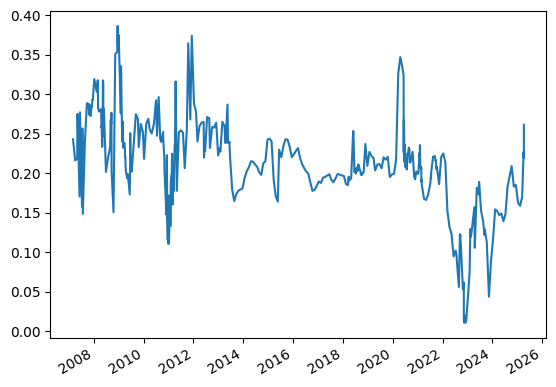

In [136]:
weight_resampled['t10'].plot()

In [134]:
snp = price_df['snp'].loc[result.index]
snp = snp / snp.iloc[0]

<Axes: >

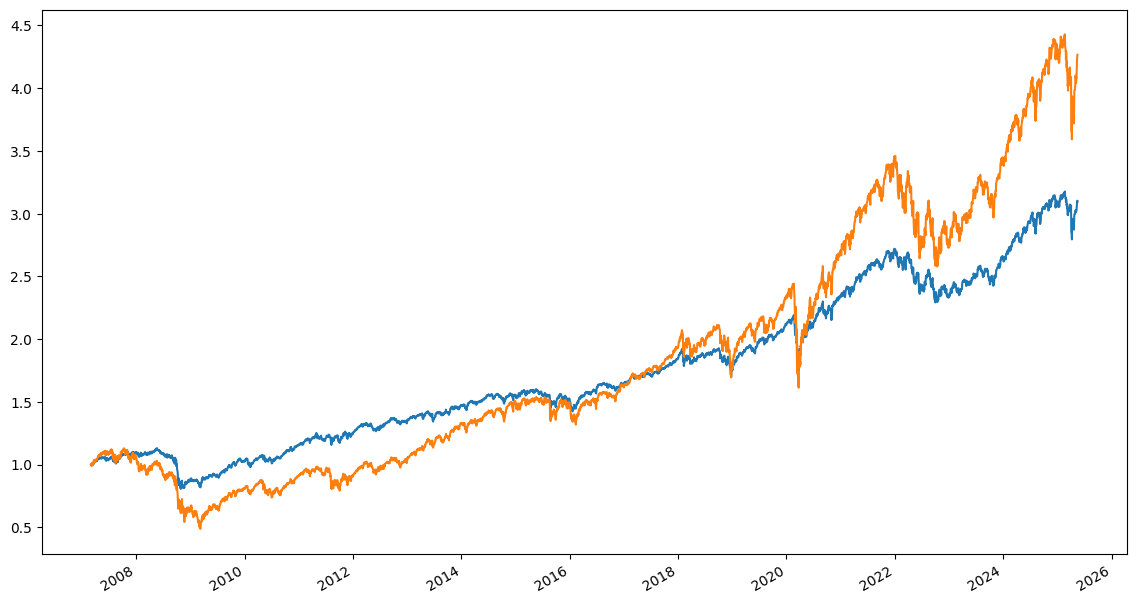

In [135]:
result.plot(figsize=(14,8))
snp.plot()